<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/3D_SEG_Salt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 14.5 MB/s eta 0:00:00


Using device: cuda
Inversion Grid: 180z (Depth) x 169x x 169y
Slice Indices for Plots: Y_index=84, Z_index=100
Phase 1: Generating Observed Data...
Phase 2: Starting Inversion...
Epoch 0 | Loss: 3.308779e-02


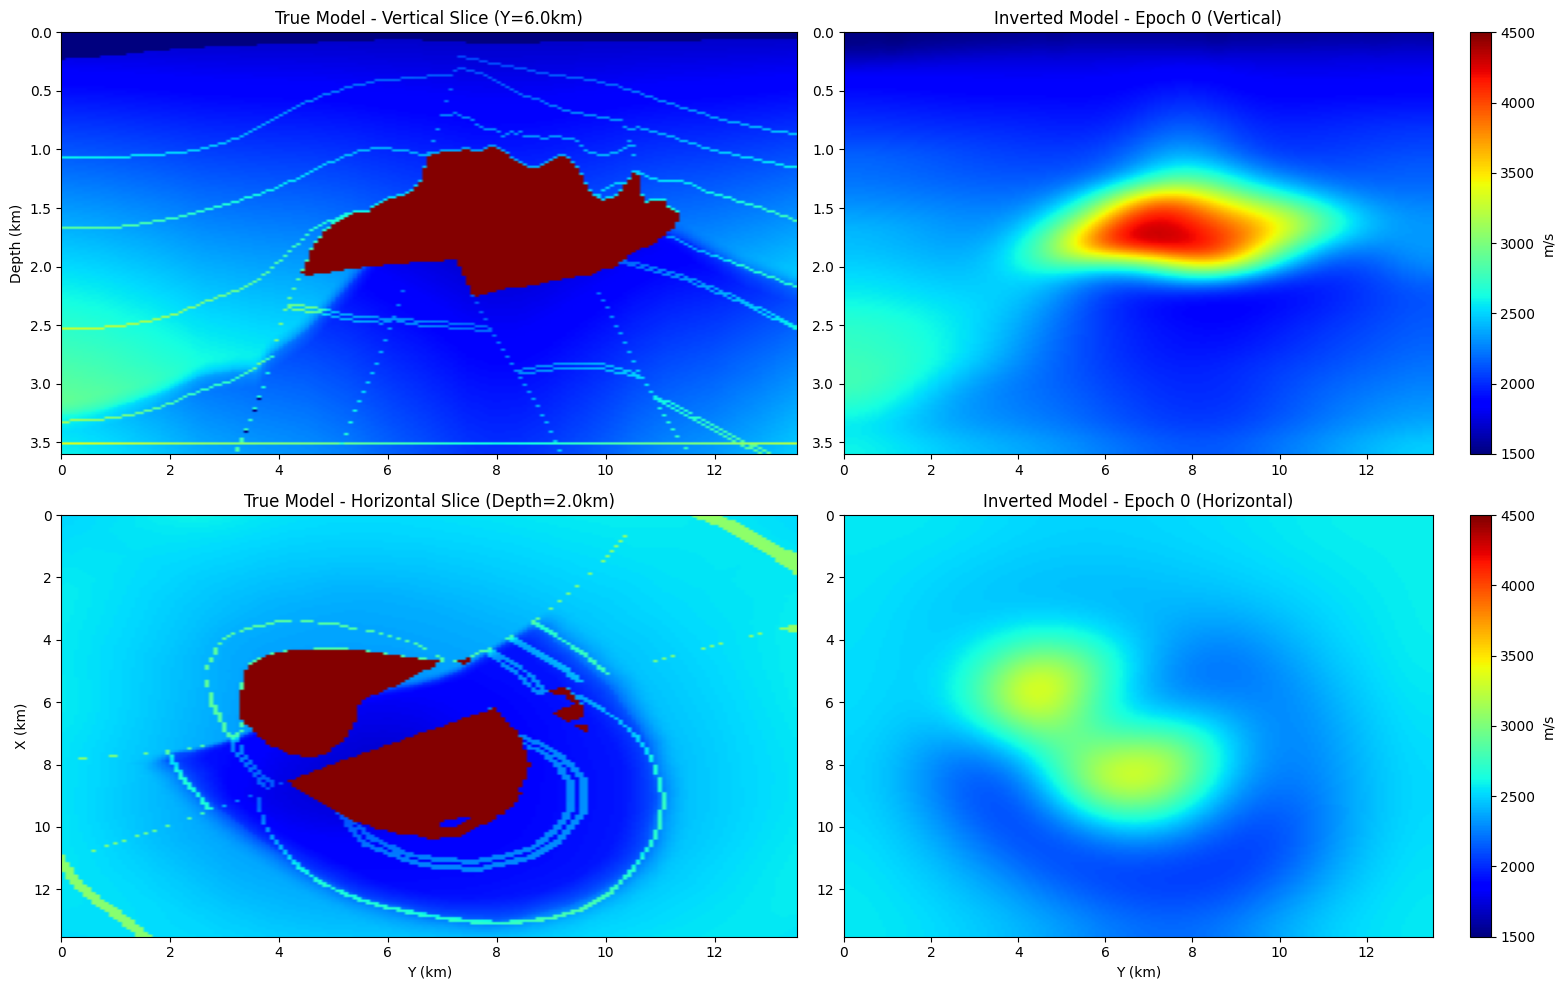

Epoch 50 | Loss: 6.511819e-05


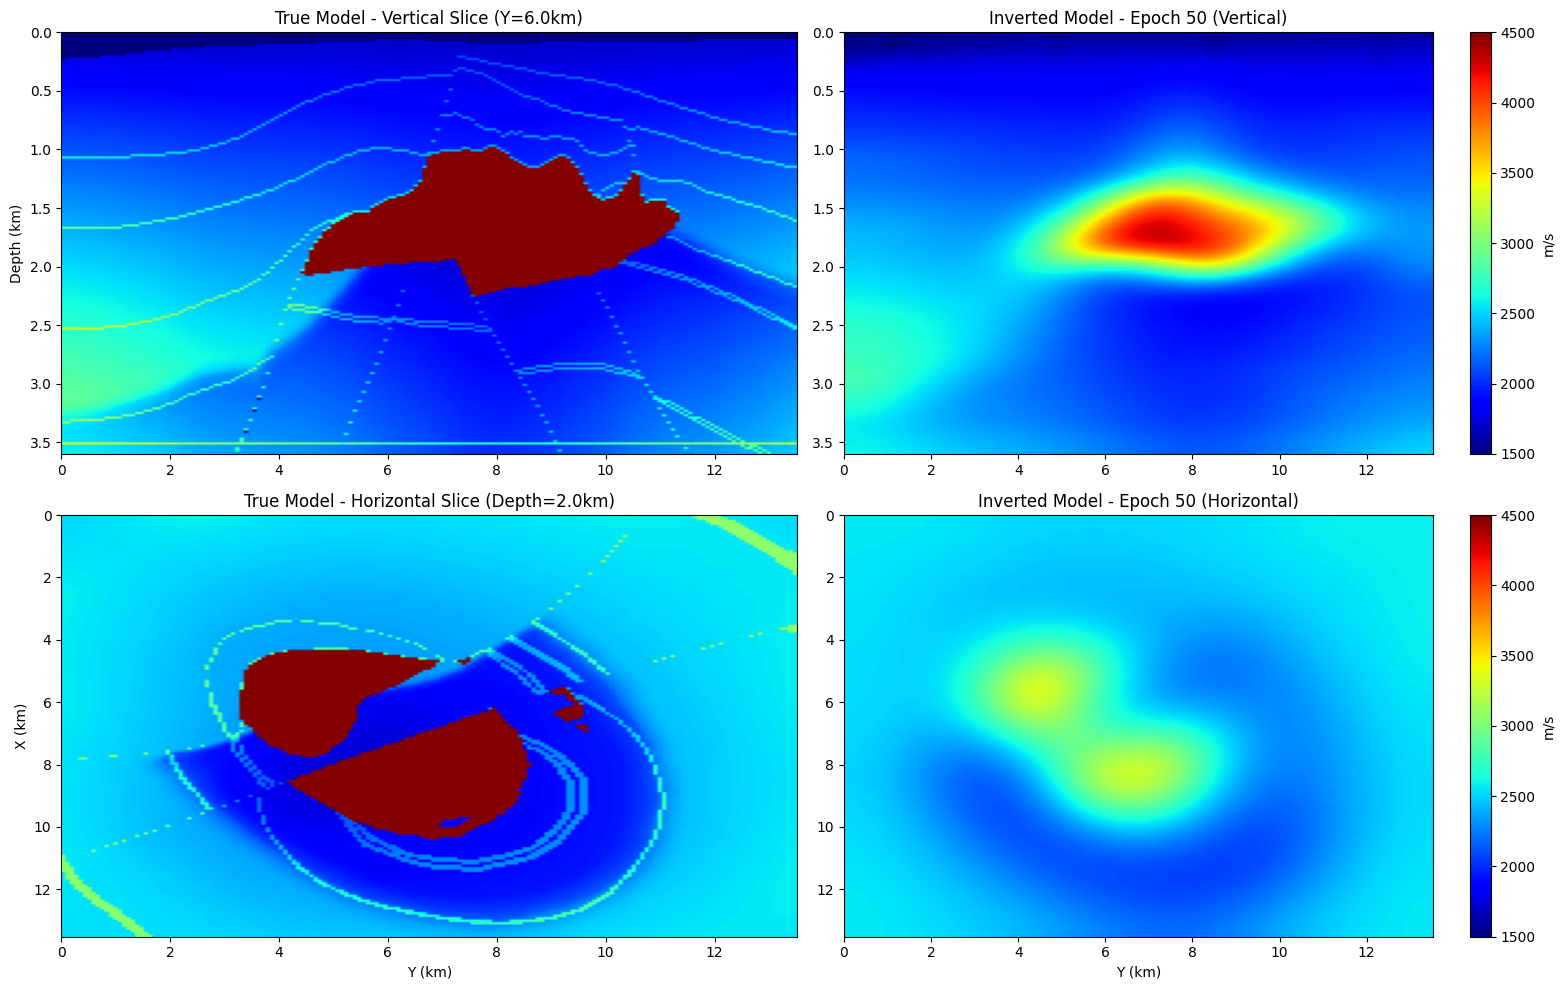

Epoch 100 | Loss: 1.999468e-05


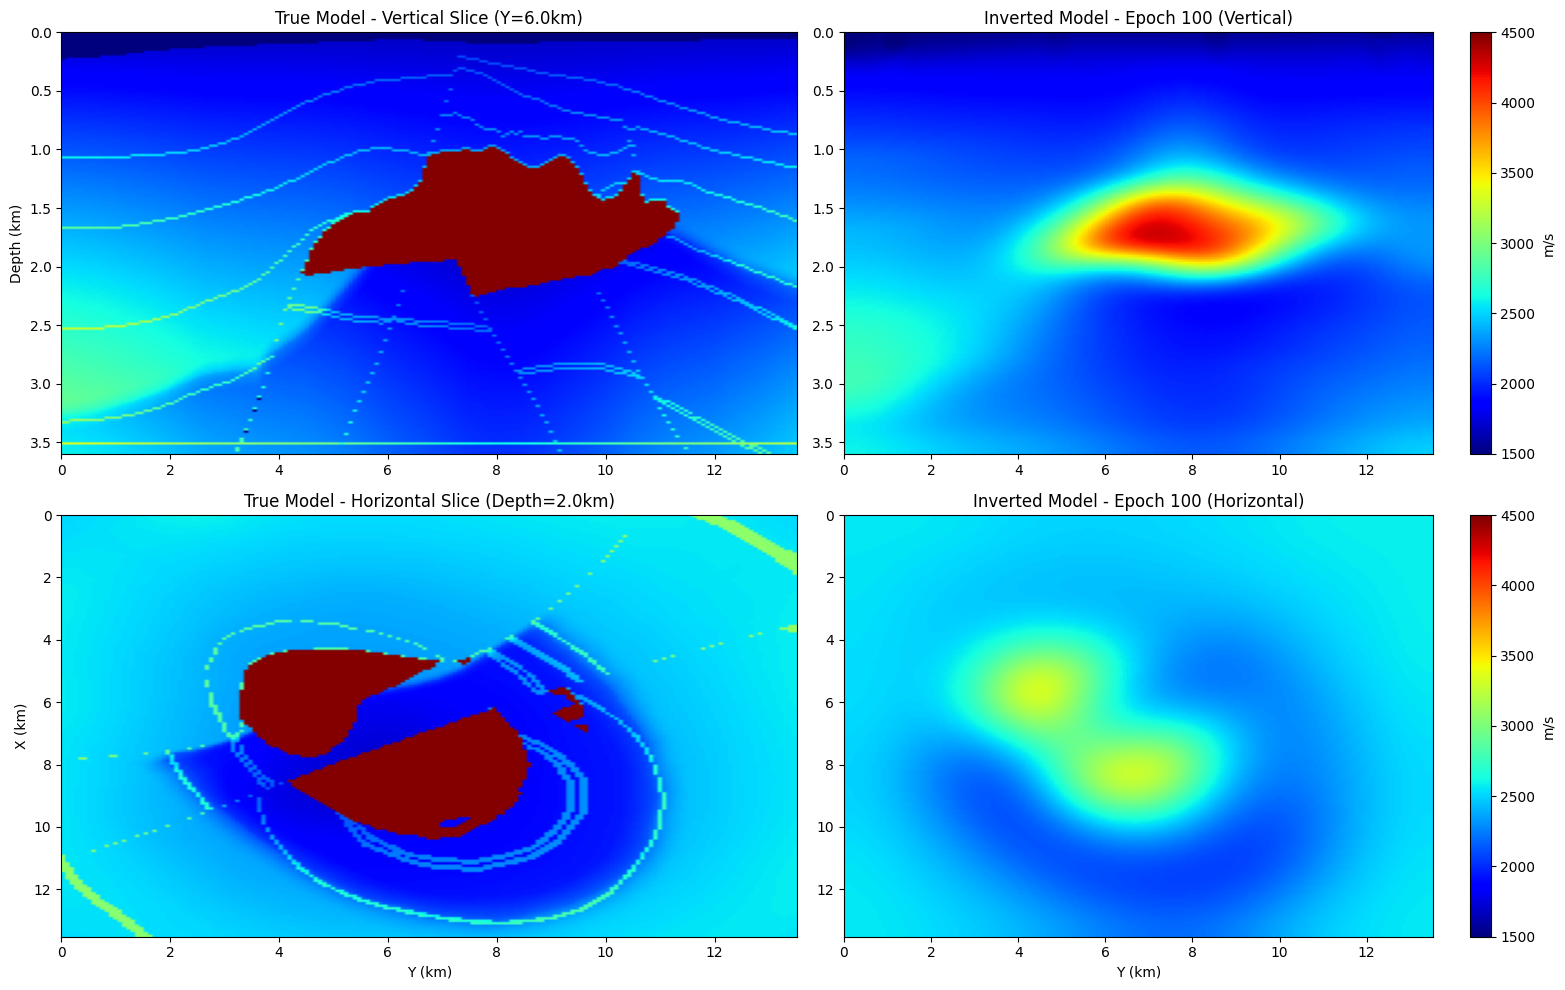

Epoch 150 | Loss: 1.225171e-05


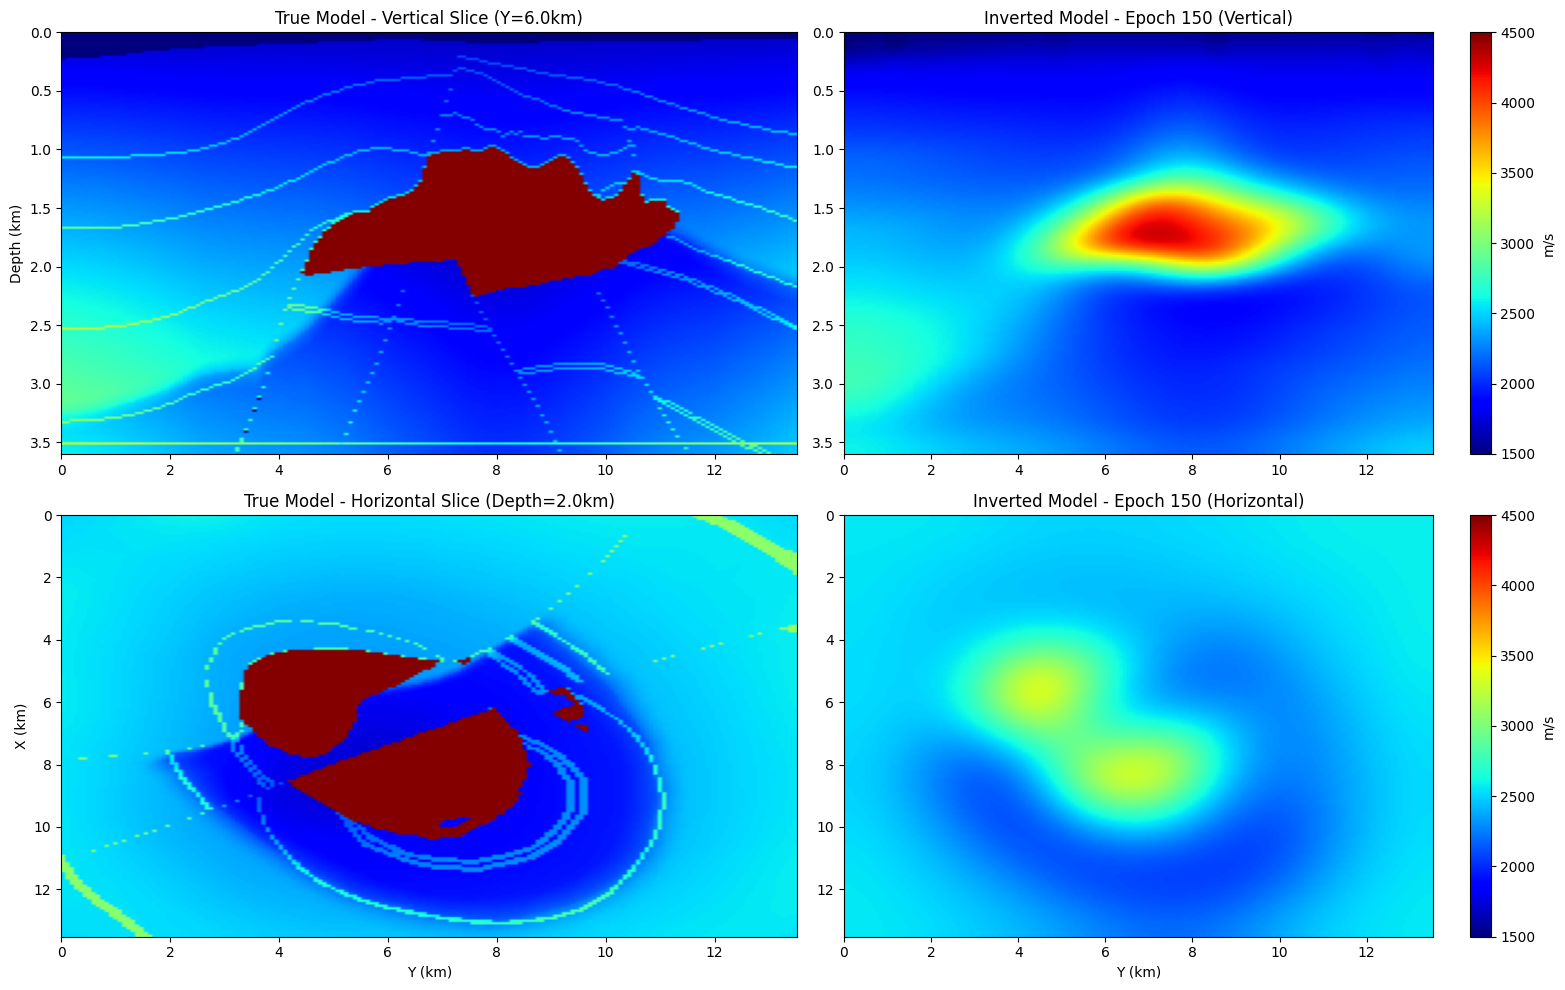

Epoch 200 | Loss: 8.494924e-06


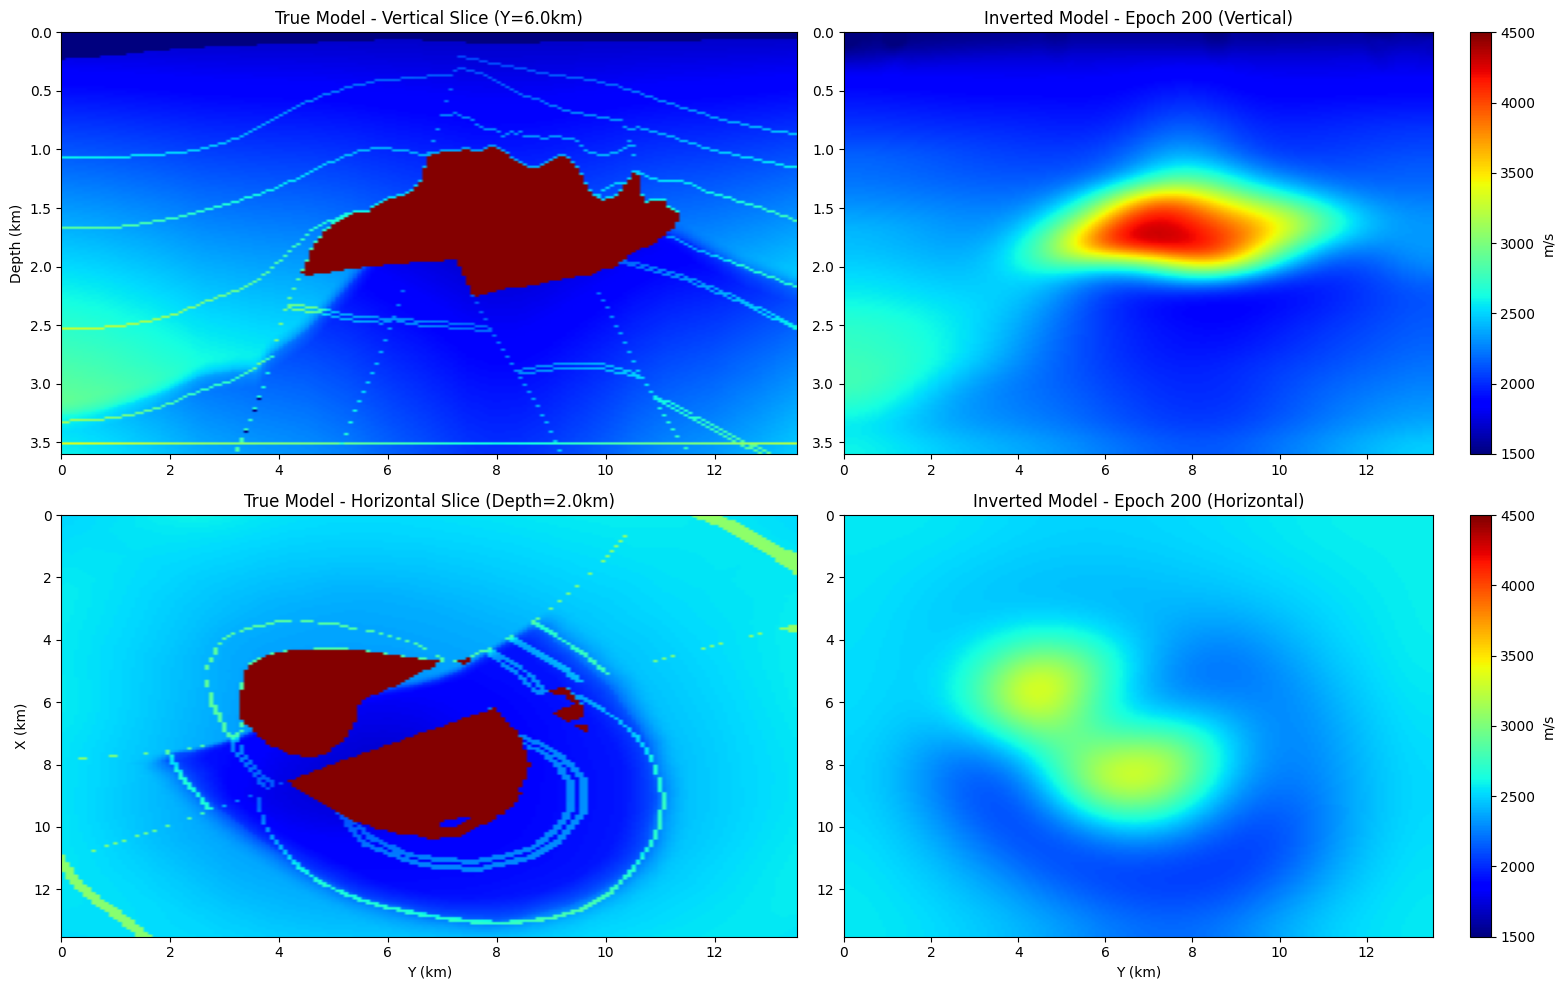

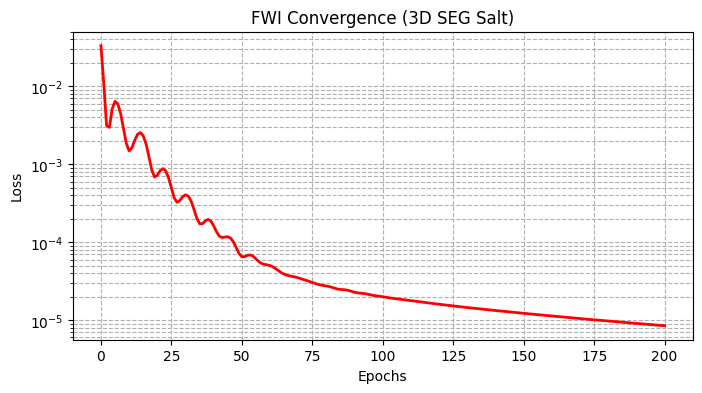

In [ ]:
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
import os
import gc

# 0. MEMORY OPTIMIZATION
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()
gc.collect()

# 1. DEVICE AND CONFIGURATION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Original Model Specifications from your script
n1, n2, n3 = 210, 676, 676  # Depth, X, Y
h_orig = 0.02               # 0.02 km = 20 meters
vp_path = '3D_seg_salt'

# 2. LOAD AND RESHAPE (FORTRAN ORDER)
# This orientation is critical to match the reference images
v_true_flat = np.fromfile(vp_path, dtype=np.float32)
v_true_full = v_true_flat[:n1*n2*n3].reshape((n1, n2, n3), order='F')

# 3. GLOBAL DOWNSAMPLING (To see the whole structure within 15GB)
# Downsample X and Y by 4, and Depth slightly to fit T4 memory
ds_factor = 4
v_true_ds = v_true_full[:180, ::ds_factor, ::ds_factor]

nz, nx, ny = v_true_ds.shape
spacing = (h_orig * 1000, h_orig * ds_factor * 1000, h_orig * ds_factor * 1000) # In meters

# Move to GPU for data generation
v_true = torch.from_numpy(v_true_ds).to(device)

# 4. INITIAL MODEL
# Create a smooth starting model
v_init_np = 1.0 / gaussian_filter(1.0 / v_true_ds, sigma=[5, 12, 12])
v1 = torch.from_numpy(v_init_np).to(device).requires_grad_(True)

print(f"Inversion Grid: {nz}z (Depth) x {nx}x x {ny}y")
print(f"Slice Indices for Plots: Y_index={ny//2}, Z_index={100}")

# 5. ACQUISITION GEOMETRY
n_shots = 12
n_receivers_per_shot = 144 # 12x12 grid
freq = 4.0
dt = 0.004
nt = 250 # Reduced to 250 steps to ensure memory stability
peak_time = 1.5 / freq

# Sources distributed across the surface
source_loc = torch.zeros(n_shots, 1, 3, dtype=torch.long, device=device)
source_loc[..., 0] = 2
sx = torch.linspace(10, nx-10, 4).long()
sy = torch.linspace(10, ny-10, 3).long()
SX, SY = torch.meshgrid(sx, sy, indexing='ij')
source_loc[:, 0, 1] = SX.flatten()[:n_shots]
source_loc[:, 0, 2] = SY.flatten()[:n_shots]

# Receivers (Surface grid)
receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 3, dtype=torch.long, device=device)
receiver_loc[..., 0] = 2
rx = torch.linspace(0, nx-1, 12).long()
ry = torch.linspace(0, ny-1, 12).long()
RX, RY = torch.meshgrid(rx, ry, indexing='ij')
receiver_loc[:, :, 1] = RX.flatten()
receiver_loc[:, :, 2] = RY.flatten()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, 1, 1).to(device))

# 6. GENERATE OBSERVED DATA
print("Phase 1: Generating Observed Data...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1],
                     receiver_locations=receiver_loc[i:i+1],
                     pml_width=[8, 8, 8, 8, 8, 8], pml_freq=freq, accuracy=2)
        observed_data[i] = out[-1]

# Clear GPU memory for the Inversion phase
v_true_cpu = v_true.cpu()
obs_cpu = observed_data.cpu()
del v_true, observed_data
torch.cuda.empty_cache()
gc.collect()

# 7. INVERSION TOOLS
optimizer = torch.optim.Adam([v1], lr=20.0)
loss_fn = torch.nn.MSELoss()
losses = []

def taper(x): return deepwave.common.cosine_taper_end(x, 15)

# 8. THE DUAL-SLICE VISUALIZATION FUNCTION
def plot_progress(epoch, v_inv):
    vi = v_inv.detach().cpu().numpy()
    vt = v_true_cpu.numpy()

    # Slices selection (Matching your reference: Y=6km and Z=2km)
    iy = int(6.0 / (h_orig * ds_factor)) # Y index approx 6km
    iz = int(2.0 / h_orig)               # Z index approx 2km

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ROW 1: VERTICAL SLICES (Depth vs Distance)
    extent_v = [0, nx*spacing[1]/1000, nz*h_orig, 0]
    im0 = axes[0,0].imshow(vt[:, :, iy], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_v)
    axes[0,0].set_title(f"True Model - Vertical Slice (Y=6.0km)")
    axes[0,0].set_ylabel("Depth (km)")

    im1 = axes[0,1].imshow(vi[:, :, iy], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_v)
    axes[0,1].set_title(f"Inverted Model - Epoch {epoch} (Vertical)")
    plt.colorbar(im1, ax=axes[0,1], label="m/s")

    # ROW 2: HORIZONTAL SLICES (X vs Y)
    extent_h = [0, ny*spacing[2]/1000, nx*spacing[1]/1000, 0]
    im2 = axes[1,0].imshow(vt[iz, :, :], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_h)
    axes[1,0].set_title(f"True Model - Horizontal Slice (Depth=2.0km)")
    axes[1,0].set_ylabel("X (km)"); axes[1,0].set_xlabel("Y (km)")

    im3 = axes[1,1].imshow(vi[iz, :, :], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_h)
    axes[1,1].set_title(f"Inverted Model - Epoch {epoch} (Horizontal)")
    axes[1,1].set_xlabel("Y (km)")
    plt.colorbar(im3, ax=axes[1,1], label="m/s")

    plt.tight_layout()
    plt.show()

# 9. INVERSION LOOP
n_epochs = 201
print("Phase 2: Starting Inversion...")

for epoch in range(n_epochs):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        obs_shot = obs_cpu[i:i+1].to(device)
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1],
                          receiver_locations=receiver_loc[i:i+1],
                          pml_width=[8, 8, 8, 8, 8, 8], pml_freq=freq, accuracy=2)

        loss = loss_fn(taper(out_pred[-1]), taper(obs_shot))
        loss = loss / n_shots
        loss.backward()
        epoch_loss += loss.item()
        del obs_shot, out_pred

    # Gradient Post-processing
    with torch.no_grad():
        grad_np = v1.grad.cpu().numpy()
        grad_smooth = gaussian_filter(grad_np, sigma=1.5)
        v1.grad.copy_(torch.from_numpy(grad_smooth).to(device))
        optimizer.step()
        v1.clamp_(min=1500, max=4500)

    losses.append(epoch_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {epoch_loss:.6e}")
        plot_progress(epoch, v1)
        torch.cuda.empty_cache()
        gc.collect()

# 10. CONVERGENCE PLOT
plt.figure(figsize=(8, 4))
plt.plot(losses, color='red', lw=2)
plt.yscale('log')
plt.title("FWI Convergence (3D SEG Salt)")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.grid(True, which='both', ls='--')
plt.show()

Using device: cuda
Inversion Grid: 180z (Depth) x 169x x 169y
Slice Indices for Plots: Y_index=84, Z_index=100
Phase 1: Generating Observed Data...


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 4.0, a minimum non-zero velocity of 1500.0, and a grid cell spacing of 80.0, there are only 4.69.
  warnings.warn(


Phase 2: Starting Inversion...


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 4.0, a minimum non-zero velocity of 1502.5008544921875, and a grid cell spacing of 80.0, there are only 4.70.
  warnings.warn(


Epoch 0 | Loss: 3.308779e-02


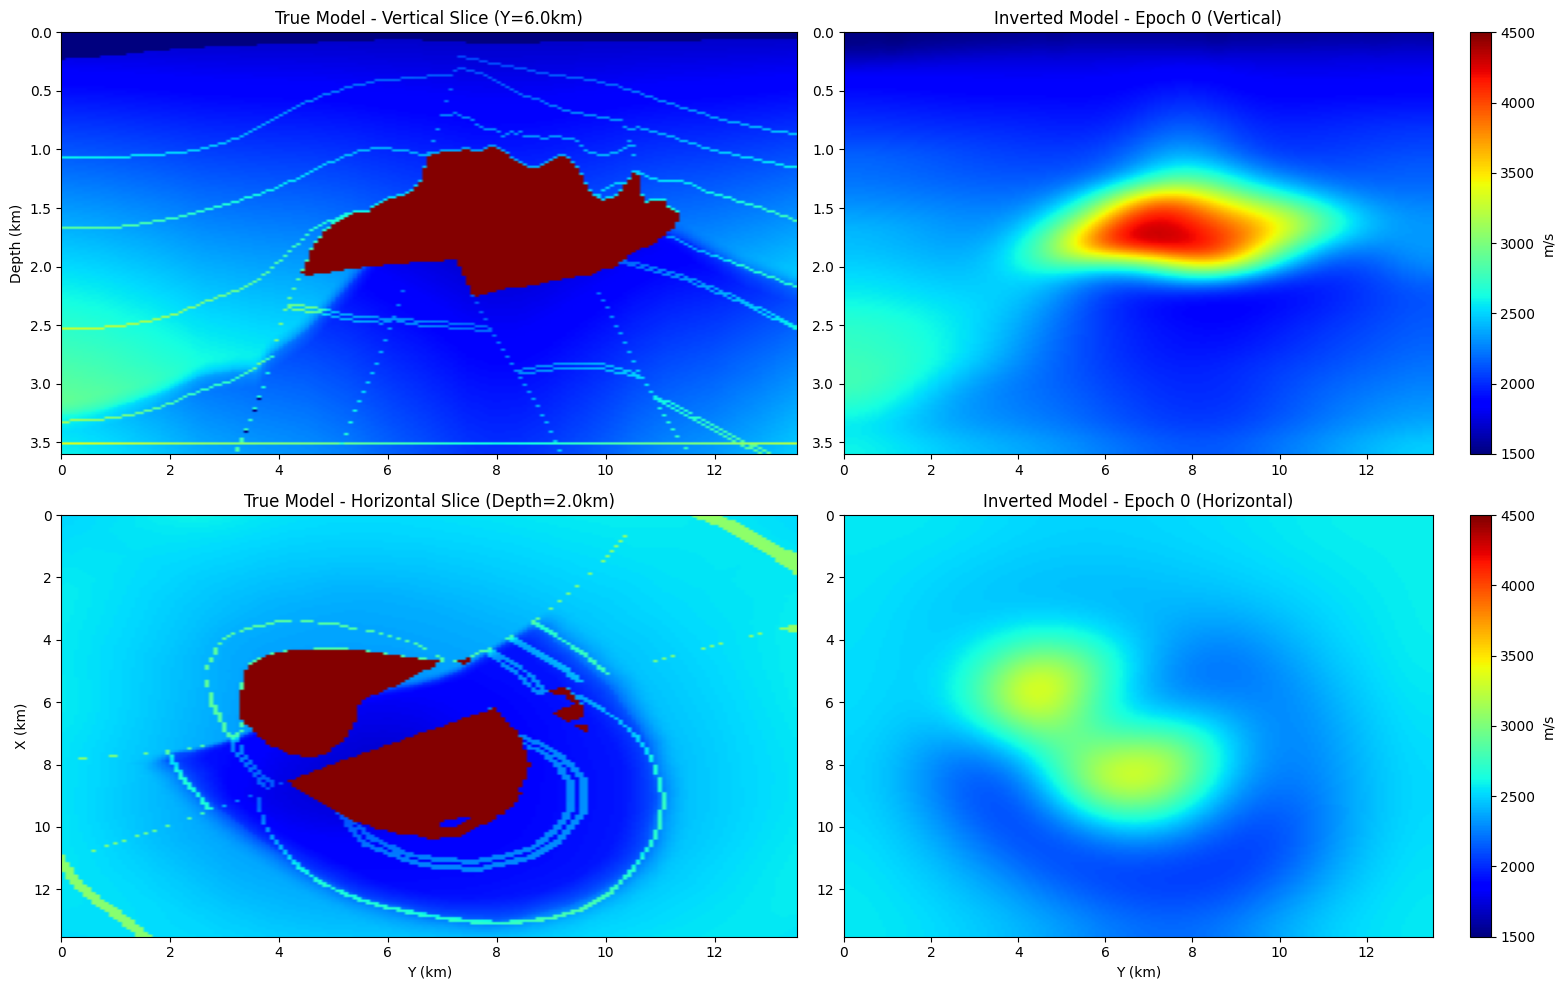

/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 4.0, a minimum non-zero velocity of 1500.0, and a grid cell spacing of 80.0, there are only 4.69.
  warnings.warn(


Epoch 50 | Loss: 6.511685e-05


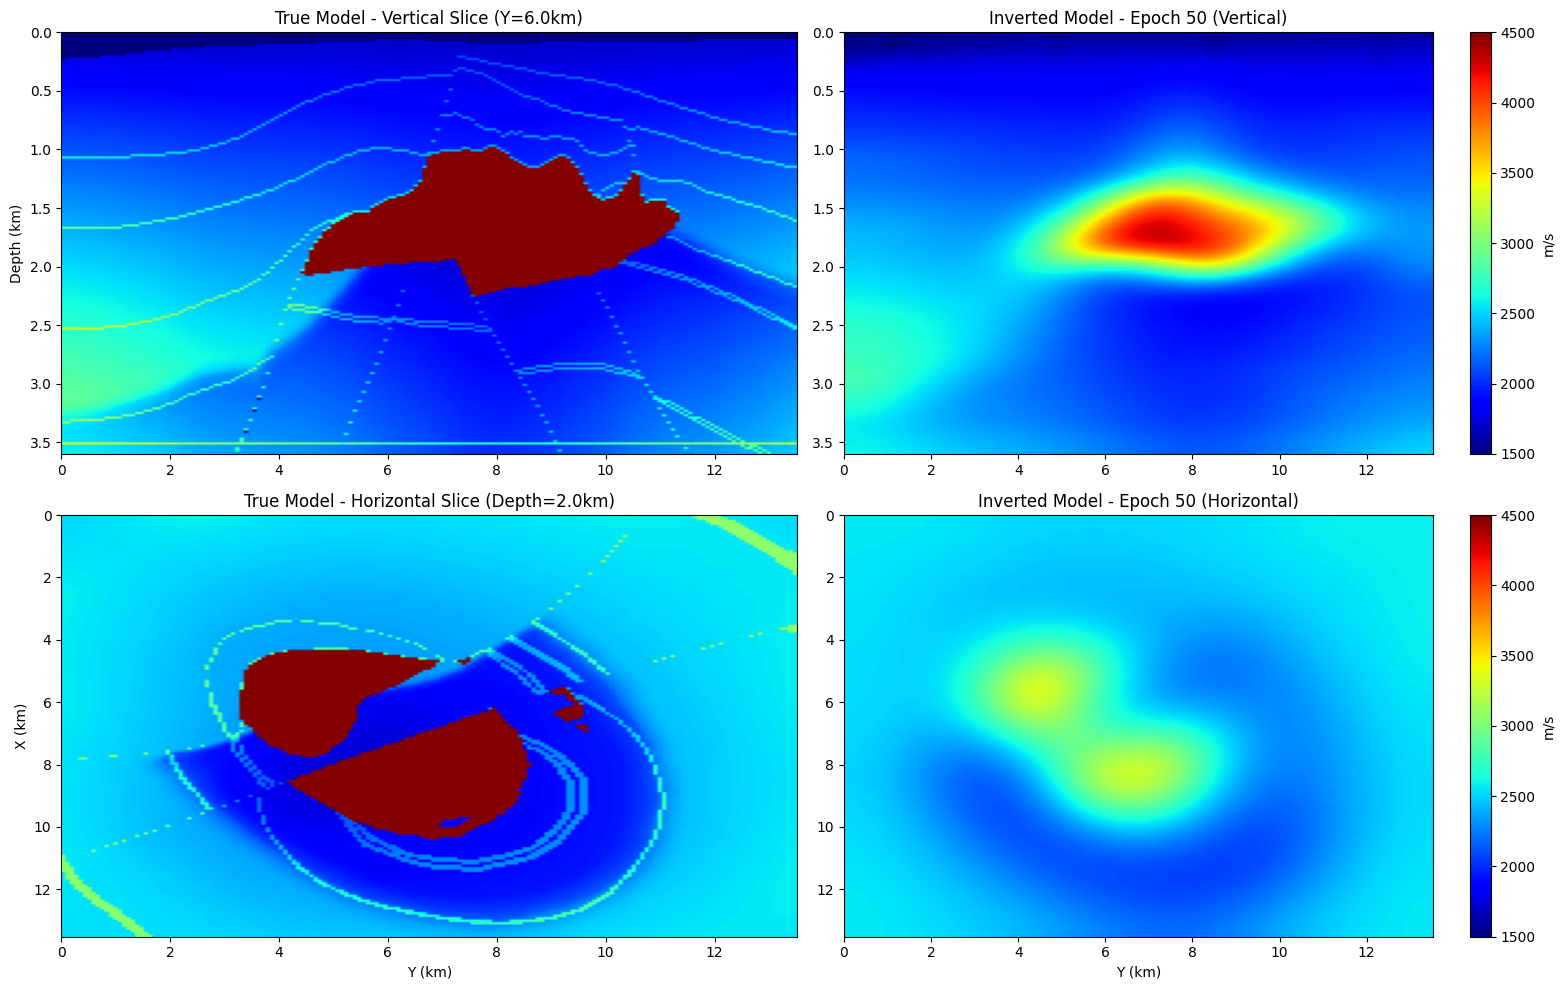

Epoch 100 | Loss: 1.999473e-05


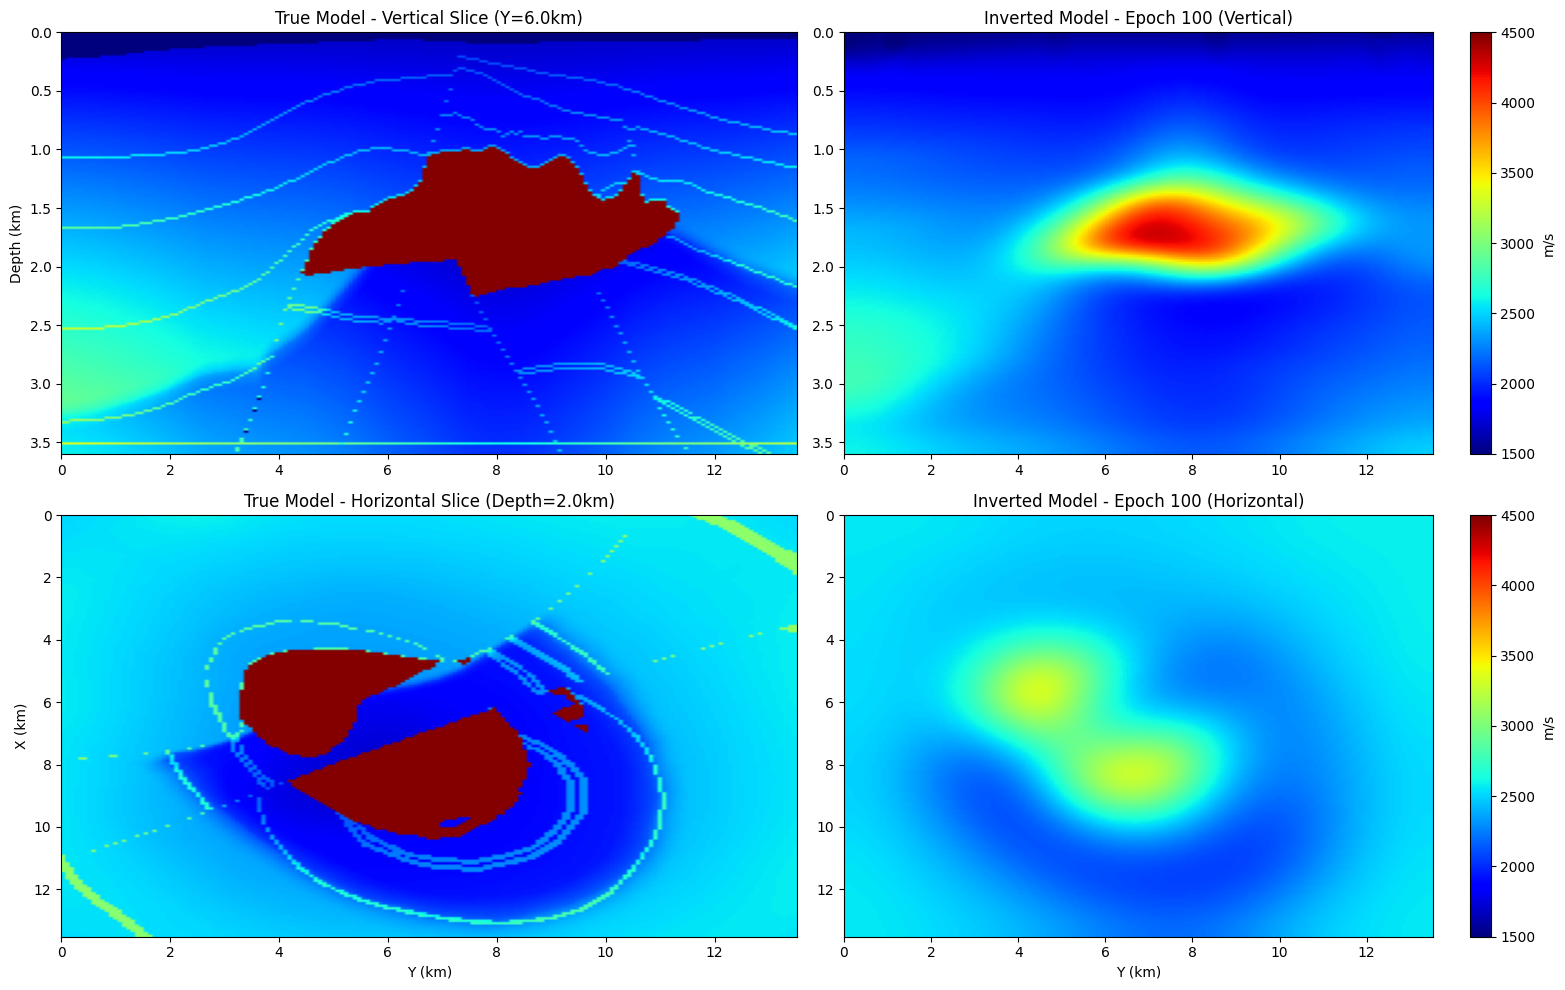

Epoch 150 | Loss: 1.225090e-05


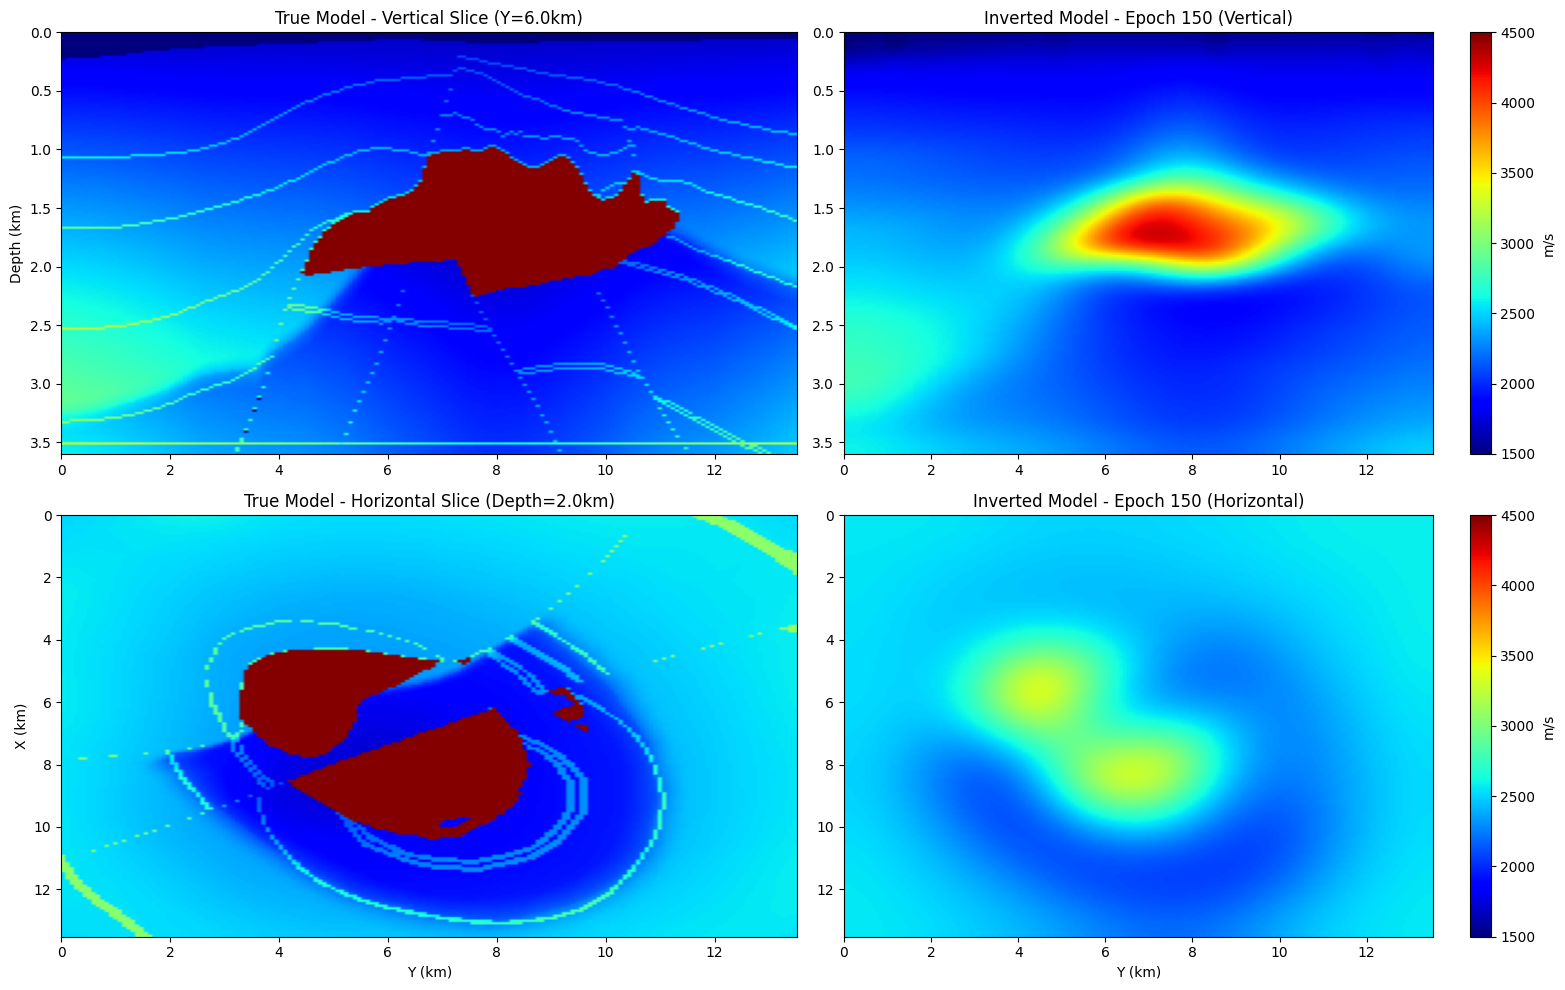

Epoch 200 | Loss: 8.494940e-06


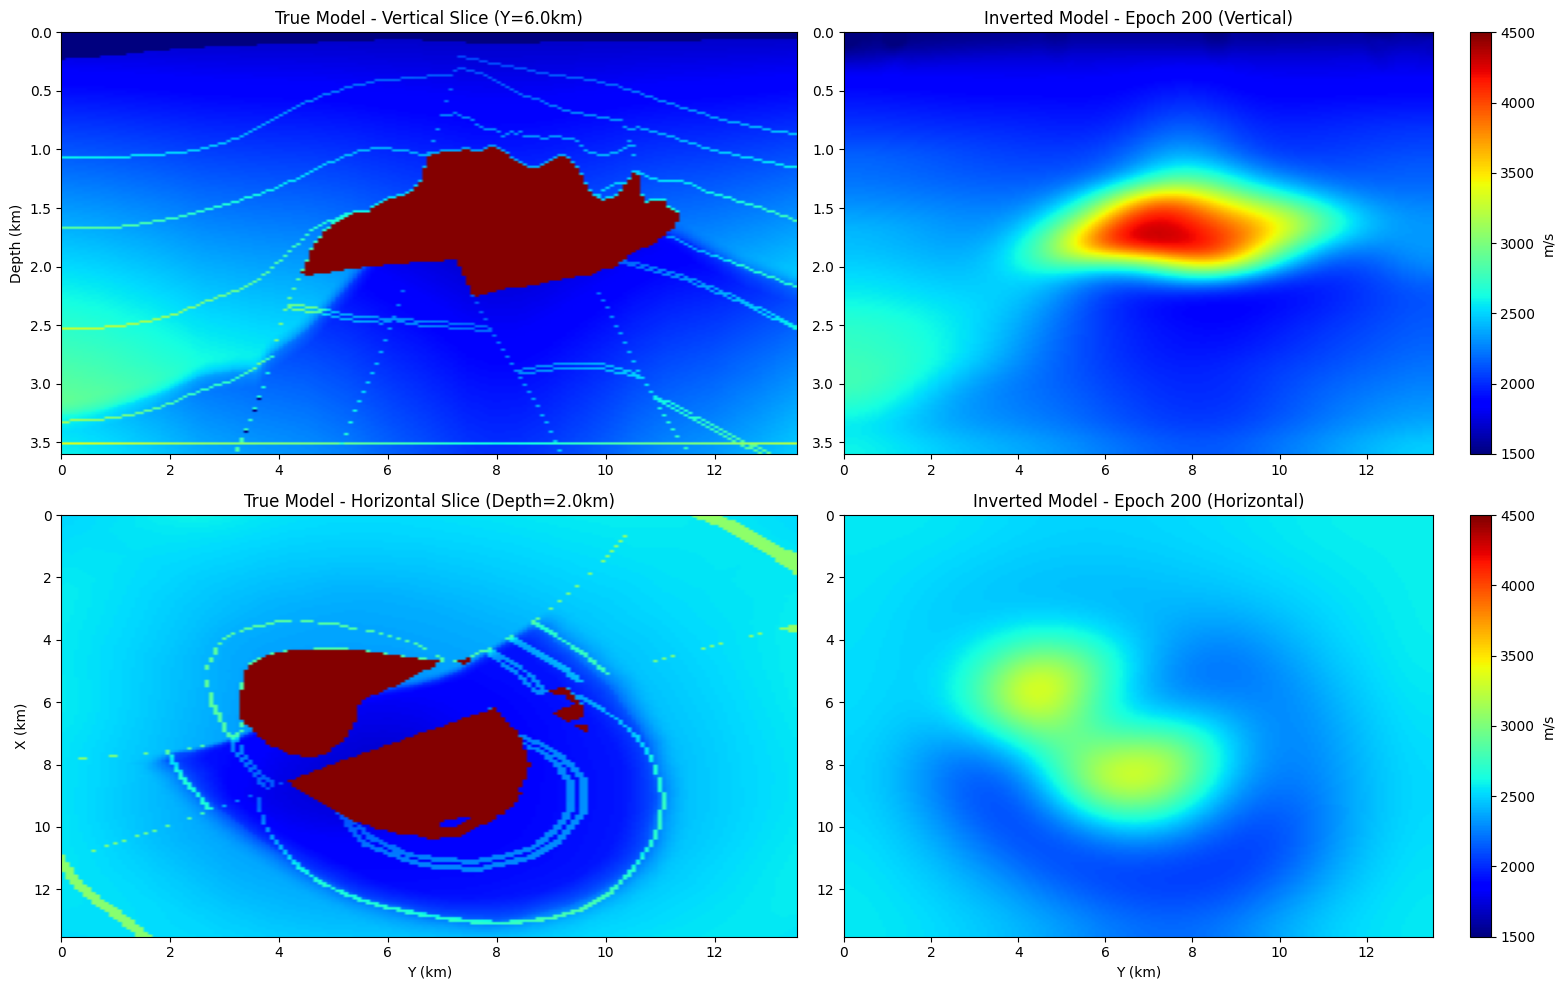

In [ ]:
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
import os
import gc

# 0. MEMORY OPTIMIZATION
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()
gc.collect()

# 1. DEVICE AND CONFIGURATION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Original Model Specifications from your script
n1, n2, n3 = 210, 676, 676  # Depth, X, Y
h_orig = 0.02               # 0.02 km = 20 meters
vp_path = '3D_seg_salt'

# 2. LOAD AND RESHAPE (FORTRAN ORDER)
# This orientation is critical to match the reference images
v_true_flat = np.fromfile(vp_path, dtype=np.float32)
v_true_full = v_true_flat[:n1*n2*n3].reshape((n1, n2, n3), order='F')

# 3. GLOBAL DOWNSAMPLING (To see the whole structure within 15GB)
# Downsample X and Y by 4, and Depth slightly to fit T4 memory
ds_factor = 4
v_true_ds = v_true_full[:180, ::ds_factor, ::ds_factor]

nz, nx, ny = v_true_ds.shape
spacing = (h_orig * 1000, h_orig * ds_factor * 1000, h_orig * ds_factor * 1000) # In meters

# Move to GPU for data generation
v_true = torch.from_numpy(v_true_ds).to(device)

# 4. INITIAL MODEL
# Create a smooth starting model
v_init_np = 1.0 / gaussian_filter(1.0 / v_true_ds, sigma=[5, 12, 12])
v1 = torch.from_numpy(v_init_np).to(device).requires_grad_(True)

print(f"Inversion Grid: {nz}z (Depth) x {nx}x x {ny}y")
print(f"Slice Indices for Plots: Y_index={ny//2}, Z_index={100}")

# 5. ACQUISITION GEOMETRY
n_shots = 12
n_receivers_per_shot = 144 # 12x12 grid
freq = 4.0
dt = 0.004
nt = 250 # Reduced to 250 steps to ensure memory stability
peak_time = 1.5 / freq

# Sources distributed across the surface
source_loc = torch.zeros(n_shots, 1, 3, dtype=torch.long, device=device)
source_loc[..., 0] = 2
sx = torch.linspace(10, nx-10, 4).long()
sy = torch.linspace(10, ny-10, 3).long()
SX, SY = torch.meshgrid(sx, sy, indexing='ij')
source_loc[:, 0, 1] = SX.flatten()[:n_shots]
source_loc[:, 0, 2] = SY.flatten()[:n_shots]

# Receivers (Surface grid)
receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 3, dtype=torch.long, device=device)
receiver_loc[..., 0] = 2
rx = torch.linspace(0, nx-1, 12).long()
ry = torch.linspace(0, ny-1, 12).long()
RX, RY = torch.meshgrid(rx, ry, indexing='ij')
receiver_loc[:, :, 1] = RX.flatten()
receiver_loc[:, :, 2] = RY.flatten()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, 1, 1).to(device))

# 6. GENERATE OBSERVED DATA
print("Phase 1: Generating Observed Data...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1],
                     receiver_locations=receiver_loc[i:i+1],
                     pml_width=[8, 8, 8, 8, 8, 8], pml_freq=freq, accuracy=2)
        observed_data[i] = out[-1]

# Clear GPU memory for the Inversion phase
v_true_cpu = v_true.cpu()
obs_cpu = observed_data.cpu()
del v_true, observed_data
torch.cuda.empty_cache()
gc.collect()

# 7. INVERSION TOOLS
optimizer = torch.optim.Adam([v1], lr=20.0)
loss_fn = torch.nn.MSELoss()
losses = []

def taper(x): return deepwave.common.cosine_taper_end(x, 15)

# 8. THE DUAL-SLICE VISUALIZATION FUNCTION
def plot_progress(epoch, v_inv):
    vi = v_inv.detach().cpu().numpy()
    vt = v_true_cpu.numpy()

    # Slices selection (Matching your reference: Y=6km and Z=2km)
    iy = int(6.0 / (h_orig * ds_factor)) # Y index approx 6km
    iz = int(2.0 / h_orig)               # Z index approx 2km

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ROW 1: VERTICAL SLICES (Depth vs Distance)
    extent_v = [0, nx*spacing[1]/1000, nz*h_orig, 0]
    im0 = axes[0,0].imshow(vt[:, :, iy], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_v)
    axes[0,0].set_title(f"True Model - Vertical Slice (Y=6.0km)")
    axes[0,0].set_ylabel("Depth (km)")

    im1 = axes[0,1].imshow(vi[:, :, iy], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_v)
    axes[0,1].set_title(f"Inverted Model - Epoch {epoch} (Vertical)")
    plt.colorbar(im1, ax=axes[0,1], label="m/s")

    # ROW 2: HORIZONTAL SLICES (X vs Y)
    extent_h = [0, ny*spacing[2]/1000, nx*spacing[1]/1000, 0]
    im2 = axes[1,0].imshow(vt[iz, :, :], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_h)
    axes[1,0].set_title(f"True Model - Horizontal Slice (Depth=2.0km)")
    axes[1,0].set_ylabel("X (km)"); axes[1,0].set_xlabel("Y (km)")

    im3 = axes[1,1].imshow(vi[iz, :, :], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_h)
    axes[1,1].set_title(f"Inverted Model - Epoch {epoch} (Horizontal)")
    axes[1,1].set_xlabel("Y (km)")
    plt.colorbar(im3, ax=axes[1,1], label="m/s")

    plt.tight_layout()
    plt.show()

# 9. INVERSION LOOP
n_epochs = 2000
print("Phase 2: Starting Inversion...")

for epoch in range(n_epochs):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        obs_shot = obs_cpu[i:i+1].to(device)
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1],
                          receiver_locations=receiver_loc[i:i+1],
                          pml_width=[8, 8, 8, 8, 8, 8], pml_freq=freq, accuracy=2)

        loss = loss_fn(taper(out_pred[-1]), taper(obs_shot))
        loss = loss / n_shots
        loss.backward()
        epoch_loss += loss.item()
        del obs_shot, out_pred

    # Gradient Post-processing
    with torch.no_grad():
        grad_np = v1.grad.cpu().numpy()
        grad_smooth = gaussian_filter(grad_np, sigma=1.5)
        v1.grad.copy_(torch.from_numpy(grad_smooth).to(device))
        optimizer.step()
        v1.clamp_(min=1500, max=4500)

    losses.append(epoch_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {epoch_loss:.6e}")
        plot_progress(epoch, v1)
        torch.cuda.empty_cache()
        gc.collect()

# 10. CONVERGENCE PLOT
plt.figure(figsize=(8, 4))
plt.plot(losses, color='red', lw=2)
plt.yscale('log')
plt.title("FWI Convergence (3D SEG Salt)")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.grid(True, which='both', ls='--')
plt.show()